In [1]:
import torch
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

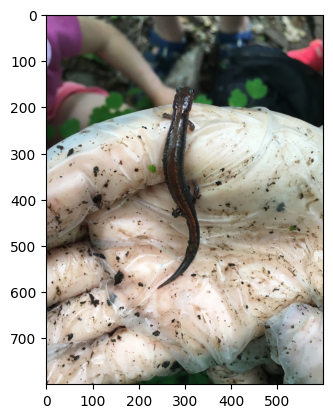

In [6]:
image_path = "inaturalist_12K/train/Amphibia/0a10c76c266e3467963c5e25353823e1.jpg"
img = mpimg.imread(image_path)


plt.imshow(img)
plt.show()

In [8]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation
from sklearn.model_selection import train_test_split

In [14]:
train_data_dir = 'inaturalist_12K/train'
test_data_dir = 'inaturalist_12K/val'

In [15]:
import os
import shutil

if not os.path.exists(train_data_dir):
    os.makedirs(train_data_dir)

# List all files in the source directory
files = os.listdir(train_data_dir)

In [16]:
files

['Plantae',
 '.DS_Store',
 'Aves',
 'Amphibia',
 'Insecta',
 'Animalia',
 'Mollusca',
 'Fungi',
 'Arachnida',
 'Reptilia',
 'Mammalia']

In [19]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Define the root directory
root_dir = 'inaturalist_12K'


# Get the list of class folders
class_folders = ['Plantae', 'Aves', 'Amphibia', 'Insecta', 'Animalia', 'Mollusca',
                 'Fungi', 'Arachnida', 'Reptilia', 'Mammalia']

# Initialize empty lists to store image paths and corresponding labels
X = []
y = []

# Iterate over each class folder
for i, class_folder in enumerate(class_folders):
    class_path = os.path.join(root_dir, 'train', class_folder)
    # Get the list of image files in the class folder
    image_files = os.listdir(class_path)
    # Append image paths and corresponding labels to the lists
    X.extend([os.path.join(class_path, img) for img in image_files])
    y.extend([i] * len(image_files))  # Assign label i to each image

# Convert labels to numpy array
y = np.array(y)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)




In [20]:
X_train[0], y_train[0]

('inaturalist_12K/train/Reptilia/e95e0320e4f33db1ae55f633f75ec0c0.jpg', 8)

In [41]:
from torchvision import transforms
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def load_images(image_paths, target_size=(224, 224)):
    images = []
    transform = transforms.Compose([
        transforms.Resize(target_size),
        transforms.ToTensor(),
    ])
  
    for img_path in image_paths:
        try:
            img = Image.open(img_path).convert("RGB")  # Convert to RGB mode
            img = transform(img)
            images.append(img)
        except:
            print(f"Error loading image: {img_path}. Skipping...")
       
    stacked_images = torch.stack(images)
    
    # Permute the dimensions to change to [8999, 224, 224, 3]
    stacked_images_permuted = stacked_images.permute(0, 2, 3, 1)
    
    return stacked_images_permuted


In [42]:
X_train_tensor = load_images(X_train)
X_val_tensor = load_images(X_val)

Error loading image: inaturalist_12K/train/Fungi/.DS_Store. Skipping...


In [43]:
X_train_tensor.shape


torch.Size([8999, 224, 224, 3])

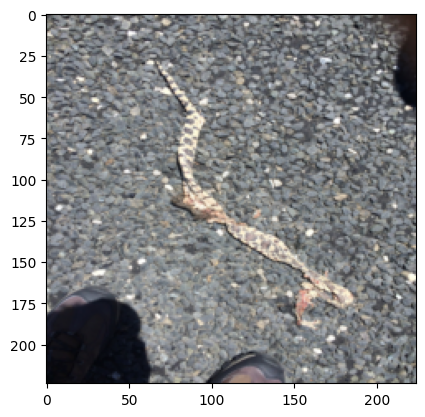

In [46]:

plt.imshow(X_train_tensor[0])
plt.show()

In [38]:
def build_cnn(num_filters, filter_size, input_shape, num_classes, dense_neurons):

    model = Sequential()

    for i in range(5):
        model.add(Conv2D(num_filters, filter_size, padding='same', input_shape=input_shape))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(dense_neurons))
    model.add(Activation('relu'))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    
    return model
    

In [47]:
num_filters = 16
filter_size = (3, 3)
input_shape = (224, 224, 3)  # Assuming input image size is 64x64 with 3 channels
num_classes = 10
dense_neurons = 256

# Build the model
model = build_cnn(num_filters, filter_size, input_shape, num_classes, dense_neurons)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 224, 224, 16)      448       
                                                                 
 activation_14 (Activation)  (None, 224, 224, 16)      0         
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 112, 112, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 112, 112, 16)      2320      
                                                                 
 activation_15 (Activation)  (None, 112, 112, 16)      0         
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 56, 56, 16)        0         
 ng2D)                                                